In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
%config InlineBackend.figure_formats = ['svg']

# Precipitation Evaluation

In this notebook, we show how we generate precipitation statistics plot, i.e., Figure 6 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [7]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'
data_path = '/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/'

In [8]:
ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


## Read the 5-year U-Net hybrid simulation and MMF reference simulation monthly data

Calculate the 5-year zonal mean precipitation climatology globally, over ocean, and over land

In [9]:
yearstr = '1year'


filenames = data_path+'h0/'+yearstr+'/unet_v5/huber_rop/*.eam.h0.000[3-8]*.nc'

ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/5year/mmf_ref/*.eam.h0.000[3-8]*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

print(ds_sp.FLDS.shape)



(60, 384)


In [10]:
filenames = data_path+'h0/5year/rnn_perturb_62843_longrun/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/1year/RNN/prevtend_10438_ep34/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/1year/RNN/prevtend_160_wcon/*.eam.h0.000[3-8]*.nc'

filenames = data_path+'h0/5year/rnn_prevtend_sepmp_slstm_58938_ep1/*.eam.h0.000[3-8]*.nc'


ds_rnn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_rnn = ds_rnn.sel(time=ds_rnn.time[1:])
ds_rnn['lev'].attrs['long_name'] = 'hybrid pressure'
print(ds_rnn.FLDS.shape)




(58, 384)


In [15]:
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_63117/*.eam.h0.000[3-8]*.nc'
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_62843/'+pattern  # 
filenames = data_path+'h0/1year/RNN/prevtend_perturb_78097/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/1year/RNN/prevtend_srnn_63117/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/1year/RNN/perturb_sgru_62843/*.eam.h0.000[3-8]*.nc'

data_path_docker = "/media/peter/samlinux/soft/ClimSim-Online/climsim-online/scratch/"

filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_40289/run/*.eam.h0.000[3-8]*.nc"


ds_srnn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_srnn = ds_srnn.sel(time=ds_nn.time[1:])
ds_srnn['lev'].attrs['long_name'] = 'hybrid pressure'


In [20]:
# calculate zonal mean precipitation averaged globally, over ocean, and over land.
sp_tmean = (ds_sp['PRECC']+ds_sp['PRECL']).mean(dim=('time')).compute()
nn_tmean = (ds_nn['PRECC']+ds_nn['PRECL']).mean(dim=('time')).compute()
rnn_tmean = (ds_srnn['PRECC']+ds_rnn['PRECL']).mean(dim=('time')).compute()

sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
rnn_zm, lats_sorted = zonal_mean_area_weighted(rnn_tmean, grid_area, lat)

scaling = 86400*1000
land_frac = ds_sp.LANDFRAC[2].compute().values
ocean_frac = 1 - land_frac
sp_zm_land, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area*land_frac, lat)
nn_zm_land, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area*land_frac, lat)
rnn_zm_land, lats_sorted = zonal_mean_area_weighted(rnn_tmean, grid_area*land_frac, lat)

sp_zm_ocean, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area*ocean_frac, lat)
nn_zm_ocean, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area*ocean_frac, lat)
rnn_zm_ocean, lats_sorted = zonal_mean_area_weighted(rnn_tmean, grid_area*ocean_frac, lat)

data_sp = scaling*xr.DataArray(sp_zm, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_nn = scaling*xr.DataArray(nn_zm, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_rnn = scaling*xr.DataArray(rnn_zm, dims=["latitude"],
                                   coords={"latitude": lats_sorted})

data_sp_land = scaling*xr.DataArray(sp_zm_land, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_nn_land = scaling*xr.DataArray(nn_zm_land, dims=["latitude"],
                                   coords={"latitude": lats_sorted})

data_rnn_land = scaling*xr.DataArray(rnn_zm_land, dims=["latitude"],
                                   coords={"latitude": lats_sorted})

data_sp_ocean = scaling*xr.DataArray(sp_zm_ocean, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_nn_ocean = scaling*xr.DataArray(nn_zm_ocean, dims=["latitude"],
                                   coords={"latitude": lats_sorted})
data_rnn_ocean = scaling*xr.DataArray(rnn_zm_ocean, dims=["latitude"],
                                   coords={"latitude": lats_sorted})

## Read the 5-year U-Net hybrid simulation and MMF reference simulation hourly data

Read the data and area weights to generate histogram of precipitation.

In [17]:
pattern='*.nc'
pattern='*0003*nc'

ds_sp_prect = xr.open_mfdataset(data_path+'precip_hourly/mmf_ref/'+pattern) #PRECT*nc')
ds_nn_prect = xr.open_mfdataset(data_path+'precip_hourly/unet_v5/huber_rop/'+pattern) #PRECT*nc')
ds_rnn_prect = xr.open_mfdataset(data_path+'precip_hourly/rnn_perturb_62843_longrun/*nc')
#ds_rnn_prect = xr.open_mfdataset(data_path+'precip_hourly/rnn_perturb_64972_ep4/'+pattern) #*nc')
#ds_rnn_prect = xr.open_mfdataset(data_path+'precip_hourly/rnn_perturb_78097_ep0/'+pattern) #*nc')
#ds_rnn_prect = xr.open_mfdataset(data_path+'precip_hourly/rnn_prevtend_slstm_91428_ep5/'+pattern) #*nc')
#ds_rnn_prect = xr.open_mfdataset(data_path+'precip_hourly/prevtend_slstm_55050_ep1/'+pattern) #*nc')
#ds_rnn_prect = xr.open_mfdataset(data_path+'precip_hourly/rnn_prevtend_sepmp_slstm_58938_ep1/*nc')

ds_rnn_prect = xr.open_mfdataset(data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_40289/run/*.eam.h2.0003*.nc")

data_sp_h2 = ds_sp_prect.PRECT.compute().values * 86400 * 1000  # Convert to mm/day
data_nn_h2 = ds_nn_prect.PRECT.compute().values * 86400 * 1000  # Convert to mm/day
data_rnn_h2 = ds_rnn_prect.PRECT.compute().values * 86400 * 1000  # Convert to mm/day

print(data_sp_h2.shape)
print(data_nn_h2.shape)
print(data_rnn_h2.shape)

(8759, 384)
(8760, 384)
(8760, 384)


In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

land_frac = ds_sp.LANDFRAC[2].compute().values  # Example, replace with the actual land_frac array
ocean_frac = 1 - land_frac

# Flatten the data
data_sp_flat = data_sp_h2.flatten()
data_nn_flat = data_nn_h2.flatten()
data_rnn_flat = data_rnn_h2.flatten()

# Repeat the grid_area to match the length of the flattened data
weights_sp = np.tile(grid_area, data_sp_h2.shape[0])
weights_nn = np.tile(grid_area, data_nn_h2.shape[0])
weights_rnn = np.tile(grid_area, data_rnn_h2.shape[0])

# Global weights
weights_sp_global = weights_sp
weights_nn_global = weights_nn
weights_rnn_global = weights_rnn

# Land weights
weights_sp_land = weights_sp * np.tile(land_frac, data_sp_h2.shape[0])
weights_nn_land = weights_nn * np.tile(land_frac, data_nn_h2.shape[0])
weights_rnn_land = weights_rnn * np.tile(land_frac, data_rnn_h2.shape[0])

# Ocean weights
weights_sp_ocean = weights_sp * np.tile(ocean_frac, data_sp_h2.shape[0])
weights_nn_ocean = weights_nn * np.tile(ocean_frac, data_nn_h2.shape[0])
weights_rnn_ocean = weights_rnn * np.tile(ocean_frac, data_rnn_h2.shape[0])


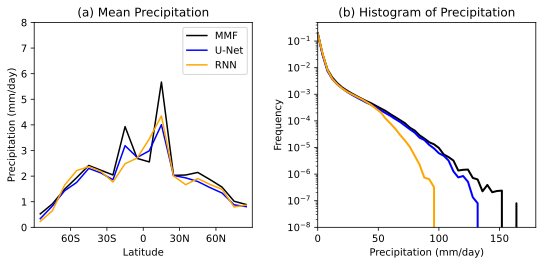

In [21]:
# Define latitude ticks and labels
lat_ticks = [-60, -30, 0, 30, 60]
lat_labels = ['60S', '30S', '0', '30N', '60N']

# Create figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.7))

# First plot: Zonal mean precipitation
ax1 = axes[0]

ax1.plot(lats_sorted, data_sp, label='MMF', color='black', linestyle='-')# , marker='o')
ax1.plot(lats_sorted, data_nn, label='U-Net', color='blue', linestyle='-')# , marker='x')
ax1.plot(lats_sorted, data_rnn, label='RNN', color='orange', linestyle='-')# , marker='o')
#ax1.plot(lats_sorted, data_srnn, label='stochasticRNN', color='red', linestyle='-')# , marker='x')


ax1.set_xlabel('Latitude')
ax1.set_ylabel('Precipitation (mm/day)')
ax1.set_xticks(lat_ticks)
ax1.set_xticklabels(lat_labels)
ax1.set_title('(a) Mean Precipitation')
ax1.legend()
ax1.set_ylim(0, 8)
ax1.set_xlim(-90,90)
# Second plot: Weighted histogram of precipitation
ax2 = axes[1]
bins_lev = np.arange(-2,180,4)
def plot_histogram(ax, data_flat, weights, label, color, linestyle):
    hist, bins = np.histogram(data_flat, bins=bins_lev, weights=weights, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.plot(bin_centers, hist, label=label, color=color, linestyle=linestyle, linewidth=2)

plot_histogram(ax2, data_sp_flat, weights_sp_global, 'MMF', 'black', '-')
plot_histogram(ax2, data_nn_flat, weights_nn_global, 'U-Net', 'blue', '-')
plot_histogram(ax2, data_rnn_flat, weights_rnn_global, 'RNN', 'orange', '-')
#plot_histogram(ax2, data_sp_flat, weights_srnn_global, 'stochasticRNN', 'red', '-')


ax2.set_yscale('log')
ax2.set_xlabel('Precipitation (mm/day)')
ax2.set_ylabel('Frequency')
ax2.set_title('(b) Histogram of Precipitation')
ax2.set_ylim(1e-8,0.5)
ax2.set_xlim(0,180)

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Adjust the width space between subplots
# Show plot
# plt.savefig('precipitation_distribution_hist_nopruning_noclass.eps', format='eps', dpi=600)
plt.show()


In [12]:
ds_sp['PRECC']

<xarray.DataArray 'PRECC' (time: 60, ncol: 384)> Size: 92kB
dask.array<getitem, shape=(60, 384), dtype=float32, chunksize=(1, 384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 480B 0003-03-01 00:00:00 ... 0008-02-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    units:         m/s
    long_name:     Convective precipitation rate (liq + ice)
    cell_methods:  time: mean

In [22]:
grid_path = '../../grid_info/ClimSim_low-res_grid-info.nc'
grid_info = xr.open_dataset(grid_path)

lat = grid_info['lat'].values
lon = grid_info['lon'].values
lon = grid_info['lon'].values
lon = ((lon + 180) % 360) - 180
level = grid_info.lev.values


In [23]:
y_ref = 3600*24*1000*ds_sp['PRECC'].mean(axis=0)
y_nn =  3600*24*1000*ds_nn['PRECC'].mean(axis=0)
y_rnn =  3600*24*1000*ds_rnn['PRECC'].mean(axis=0)
y_srnn =  3600*24*1000*ds_srnn['PRECC'].mean(axis=0)

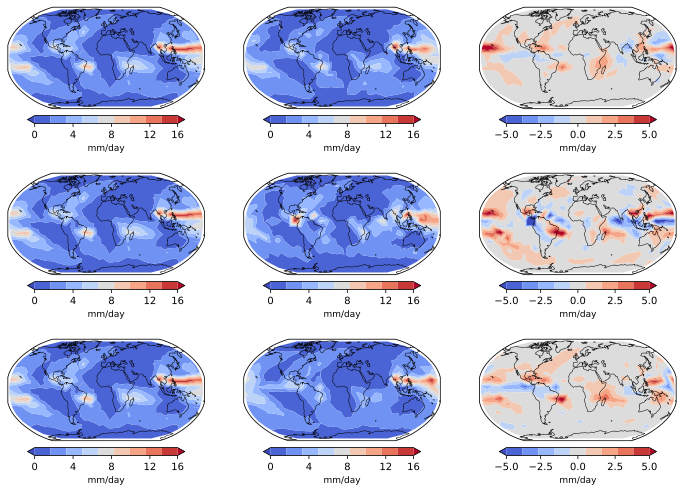

In [24]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.image as imag
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, gc, glob
from tqdm import tqdm
import shutil
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from sklearn.metrics import r2_score
import psutil
import time
import argparse
import sys

import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.image as imag
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

cmap = 'coolwarm'

y_ref_min = float(y_ref.min())
y_ref_max = float(y_ref.max())
y_diff_min, y_diff_max = -4.8, 4.8

# levels = np.linspace(y_ref_min, y_ref_max, 20)

fig = plt.figure(figsize=(12, 8.5))#, constrained_layout=True)  # Increased width to accommodate third column

gs = fig.add_gridspec(3, 3)  # Changed to 2x3 grid

vmins = [y_ref_min, y_ref_min, y_diff_min]
vmaxs = [y_ref_max, y_ref_max, y_diff_max] 

irow = 0

for y_pred in [y_nn,y_rnn, y_srnn]:
    y_diff = y_ref - y_pred
    i = 0
    for var in y_ref, y_pred, y_diff:
        levels = np.linspace(vmins[i], vmaxs[i], 10)
        
        ax1 = fig.add_subplot(gs[irow, i], projection=ccrs.Robinson())
        
       # levels = np.linspace(y_ref_min, y_ref_max, 20)
        
        contour_sp = ax1.tricontourf(
            lon, lat, var, 
            transform=ccrs.PlateCarree(),  # Data is in lat-lon coordinates
            cmap=cmap,  # Adjust colormap as needed
            levels=levels,  # Number of contour levels
            extend='both',  # Extend beyond data range
            vmin=vmins[i],
            vmax=vmaxs[i])
        
        ax1.tricontourf(lon, lat, var)
        
        units = 'mm/day'
        ax1.coastlines(linewidth=0.5, color='black')
        #ax2.coastlines(linewidth=0.5, color='black')
        #ax3.coastlines(linewidth=0.5, color='black')
        # Add a colorbar
        cbar_sp = plt.colorbar(contour_sp, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8)
        cbar_sp.set_label(f'{units}', fontsize = 9)  # Adjust label to match your data
        cbar_sp.locator = ticker.MaxNLocator(nbins=4)
        
       # ax1.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        
        ax1.set_extent([-180, 180, -90, 90],
                      crs=ccrs.PlateCarree()) 
        i = i + 1
    irow = irow + 1
#plt.subplots_adjust(wspace=0.3)  # Adjust the width space between subplots


In [37]:
y_ref

<xarray.DataArray 'PRECC' (ncol: 384)> Size: 2kB
dask.array<mul, shape=(384,), dtype=float32, chunksize=(384,), chunktype=numpy.ndarray>
Dimensions without coordinates: ncol